In [1]:
from gcn_scripts import DenseGCN_Model, graph, coarsening
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\murray\AppData\Roaming\Python\Python36\s

In [2]:
train_set = pd.read_csv("data/final_format/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/final_format/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/final_format/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/final_format/test_label.csv",header=None).to_numpy()

In [3]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14393, 4096) (14393, 1) (3599, 4096) (3599, 1)


In [4]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 4096) (14392, 1) (3598, 4096) (3598, 1)


In [5]:
train_set = train_set.reshape((-1,64,64))
train_set = np.transpose(train_set, (0, 2, 1))
test_set = test_set.reshape((-1,64,64))
test_set = np.transpose(test_set, (0, 2, 1))
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 64, 64) (14392,) (3598, 64, 64) (3598,)


In [6]:
#set data for gcn model
train_label_holder = np.ones((0))
test_label_holder = np.ones((0))

for i in range(train_set.shape[0]):
    temp = np.full((64), train_label[i])
    train_label_holder = np.concatenate((train_label_holder, temp), axis=0)
    
for i in range(test_set.shape[0]):
    temp = np.full((64), test_label[i])
    test_label_holder = np.concatenate((test_label_holder, temp), axis=0)

train_set = train_set.reshape((-1,64))
test_set = test_set.reshape((-1,64))
train_label = train_label_holder
test_label = test_label_holder
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(921088, 64) (921088,) (230272, 64) (230272,)


In [7]:
dist, idx = graph.distance_scipy_spatial(train_set.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

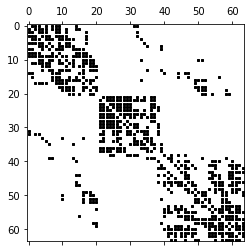

In [8]:
plt.spy(A, markersize=2, color='black');

In [9]:
graphs, perm = coarsening.coarsen(A, levels=5, self_connections=False)

Layer 0: M_0 = |V| = 96 nodes (32 added),|E| = 401 edges
Layer 1: M_1 = |V| = 48 nodes (15 added),|E| = 167 edges
Layer 2: M_2 = |V| = 24 nodes (7 added),|E| = 60 edges
Layer 3: M_3 = |V| = 12 nodes (3 added),|E| = 24 edges
Layer 4: M_4 = |V| = 6 nodes (1 added),|E| = 9 edges
Layer 5: M_5 = |V| = 3 nodes (0 added),|E| = 3 edges


In [10]:
X_train = coarsening.perm_data(train_set, perm)
X_test  = coarsening.perm_data(test_set,  perm)

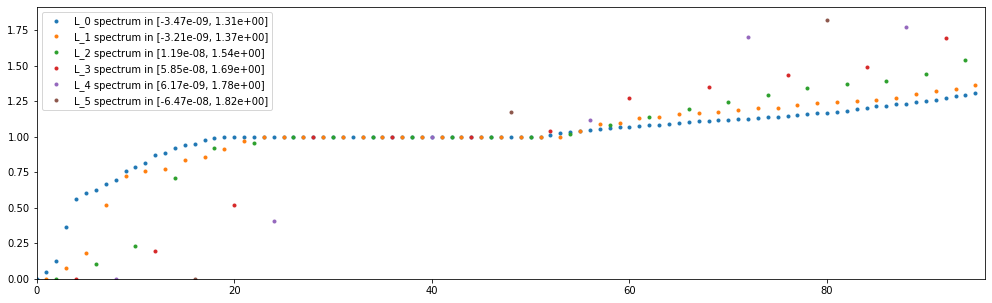

In [11]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [12]:
params = dict()
params['dir_name']       = 'DenseGCN'
params['num_epochs']     = 300
params['batch_size']     = 1024
params['eval_frequency'] = 100

# Building blocks.
params['filter'] = 'chebyshev5'
params['brelu']  = 'b2relu'
params['pool']   = 'mpool1'

# Architecture.
params['F'] = [16, 32, 64, 128, 256, 512]         # Number of graph convolutional filters.
params['K'] = [2, 2, 2, 2, 2, 2]                  # Polynomial orders.
params['p'] = [1, 1, 1, 1, 1, 1]                  # Pooling sizes.
params['M'] = [4]                                 # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 0.001     # L2 regularization
params['dropout']        = 0.50      # Dropout rate
params['learning_rate']  = 0.01      # Learning rate
params['decay_rate']     = 1         # Learning rate Decay == 1 means no Decay
params['momentum']       = 0         # momentum == 0 means Use Adam Optimizer
params['decay_steps']    = np.shape(train_set)[0] / params['batch_size']

In [ ]:
model = DenseGCN_Model.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, train_label, X_test, test_label)

NN architecture
input: M_0 = 96
layer 1: cgconv1
representation: M_0 * F_1 / p_1 = 96 * 16 / 1 = 1536
weights: F_0 * F_1 * K_1 = 1 * 16 * 2 = 32
biases: M_1 * F_1 = 96 * 16 = 1536
layer 2: cgconv2
representation: M_1 * F_2 / p_2 = 96 * 32 / 1 = 3072
weights: F_1 * F_2 * K_2 = 16 * 32 * 2 = 1024
biases: M_2 * F_2 = 96 * 32 = 3072
layer 3: cgconv3
representation: M_2 * F_3 / p_3 = 96 * 64 / 1 = 6144
weights: F_2 * F_3 * K_3 = 32 * 64 * 2 = 4096
biases: M_3 * F_3 = 96 * 64 = 6144
layer 4: cgconv4
representation: M_3 * F_4 / p_4 = 96 * 128 / 1 = 12288
weights: F_3 * F_4 * K_4 = 64 * 128 * 2 = 16384
biases: M_4 * F_4 = 96 * 128 = 12288
layer 5: cgconv5
representation: M_4 * F_5 / p_5 = 96 * 256 / 1 = 24576
weights: F_4 * F_5 * K_5 = 128 * 256 * 2 = 65536
biases: M_5 * F_5 = 96 * 256 = 24576
layer 6: cgconv6
representation: M_5 * F_6 / p_6 = 96 * 512 / 1 = 49152
weights: F_5 * F_6 * K_6 = 256 * 512 * 2 = 262144
biases: M_6 * F_6 = 96 * 512 = 49152
layer 7: logits (softmax)
representation: M_

Training   accuracy: 58.691406 (601 / 1024), f1 (weighted): 58.562140, loss: 0.964029
validation accuracy: 50.931507 (117281 / 230272), f1 (weighted): 50.347762, loss: 1.145522
time: 1190s (wall 815s)


step 2100 / 269850 (epoch 2.33 / 300):
learning_rate = 0.010000, loss_average = 0.937116
Training   accuracy: 62.011719 (635 / 1024), f1 (weighted): 61.647694, loss: 0.912085
validation accuracy: 50.650101 (116633 / 230272), f1 (weighted): 49.649193, loss: 1.155773
time: 1249s (wall 856s)


step 2200 / 269850 (epoch 2.45 / 300):
learning_rate = 0.010000, loss_average = 0.932010
Training   accuracy: 61.816406 (633 / 1024), f1 (weighted): 61.575114, loss: 0.905276
validation accuracy: 50.693093 (116732 / 230272), f1 (weighted): 49.810609, loss: 1.158803
time: 1307s (wall 896s)


step 2300 / 269850 (epoch 2.56 / 300):
learning_rate = 0.010000, loss_average = 0.907928
Training   accuracy: 62.011719 (635 / 1024), f1 (weighted): 61.625991, loss: 0.913522
validation accuracy: 52.490967 (120872

Training   accuracy: 78.125000 (800 / 1024), f1 (weighted): 77.930978, loss: 0.588588
validation accuracy: 58.998054 (135856 / 230272), f1 (weighted): 58.246184, loss: 1.037694
time: 2821s (wall 1930s)


step 4900 / 269850 (epoch 5.45 / 300):
learning_rate = 0.010000, loss_average = 0.650986
Training   accuracy: 74.804688 (766 / 1024), f1 (weighted): 74.698132, loss: 0.611653
validation accuracy: 58.704054 (135179 / 230272), f1 (weighted): 58.510271, loss: 1.045938
time: 2879s (wall 1969s)


step 5000 / 269850 (epoch 5.56 / 300):
learning_rate = 0.010000, loss_average = 0.646994
Training   accuracy: 76.953125 (788 / 1024), f1 (weighted): 76.759669, loss: 0.607047
validation accuracy: 59.120084 (136137 / 230272), f1 (weighted): 58.963745, loss: 1.027933
time: 2936s (wall 2008s)


step 5100 / 269850 (epoch 5.67 / 300):
learning_rate = 0.010000, loss_average = 0.621348
Training   accuracy: 77.636719 (795 / 1024), f1 (weighted): 77.488473, loss: 0.584651
validation accuracy: 60.435485 (139

Training   accuracy: 79.687500 (816 / 1024), f1 (weighted): 79.611114, loss: 0.543811
validation accuracy: 60.618747 (139588 / 230272), f1 (weighted): 60.175969, loss: 1.042265
time: 4446s (wall 3036s)


step 7700 / 269850 (epoch 8.56 / 300):
learning_rate = 0.010000, loss_average = 0.568992
Training   accuracy: 77.246094 (791 / 1024), f1 (weighted): 77.218824, loss: 0.568792
validation accuracy: 60.744250 (139877 / 230272), f1 (weighted): 60.629423, loss: 1.030832
time: 4515s (wall 3084s)


step 7800 / 269850 (epoch 8.67 / 300):
learning_rate = 0.010000, loss_average = 0.569594
Training   accuracy: 80.468750 (824 / 1024), f1 (weighted): 80.398422, loss: 0.533541
validation accuracy: 60.682584 (139735 / 230272), f1 (weighted): 60.494185, loss: 1.025727
time: 4575s (wall 3125s)


step 7900 / 269850 (epoch 8.78 / 300):
learning_rate = 0.010000, loss_average = 0.563033
Training   accuracy: 78.613281 (805 / 1024), f1 (weighted): 78.690513, loss: 0.547785
validation accuracy: 61.158109 (140

Training   accuracy: 81.933594 (839 / 1024), f1 (weighted): 81.845944, loss: 0.483084
validation accuracy: 61.248437 (141038 / 230272), f1 (weighted): 61.136532, loss: 1.068427
time: 6132s (wall 4187s)


step 10500 / 269850 (epoch 11.67 / 300):
learning_rate = 0.010000, loss_average = 0.524587
Training   accuracy: 81.542969 (835 / 1024), f1 (weighted): 81.746032, loss: 0.517129
validation accuracy: 60.656094 (139674 / 230272), f1 (weighted): 60.944821, loss: 1.075193
time: 6190s (wall 4227s)


step 10600 / 269850 (epoch 11.78 / 300):
learning_rate = 0.010000, loss_average = 0.509188
Training   accuracy: 83.105469 (851 / 1024), f1 (weighted): 83.031541, loss: 0.459056
validation accuracy: 62.166916 (143153 / 230272), f1 (weighted): 62.093746, loss: 1.019460
time: 6248s (wall 4267s)


step 10700 / 269850 (epoch 11.90 / 300):
learning_rate = 0.010000, loss_average = 0.509723
Training   accuracy: 85.058594 (871 / 1024), f1 (weighted): 85.025335, loss: 0.438709
validation accuracy: 62.16257

Training   accuracy: 83.300781 (853 / 1024), f1 (weighted): 83.288911, loss: 0.464838
validation accuracy: 62.793566 (144596 / 230272), f1 (weighted): 62.592712, loss: 1.026907
time: 7807s (wall 5338s)


step 13300 / 269850 (epoch 14.79 / 300):
learning_rate = 0.010000, loss_average = 0.473534
Training   accuracy: 85.351562 (874 / 1024), f1 (weighted): 85.257766, loss: 0.419402
validation accuracy: 62.306316 (143474 / 230272), f1 (weighted): 62.303778, loss: 1.040858
time: 7867s (wall 5380s)


step 13400 / 269850 (epoch 14.90 / 300):
learning_rate = 0.010000, loss_average = 0.476884
Training   accuracy: 83.691406 (857 / 1024), f1 (weighted): 83.676235, loss: 0.442371
validation accuracy: 63.050653 (145188 / 230272), f1 (weighted): 62.934161, loss: 1.010153
time: 7926s (wall 5421s)


step 13500 / 269850 (epoch 15.01 / 300):
learning_rate = 0.010000, loss_average = 0.463021
Training   accuracy: 83.886719 (859 / 1024), f1 (weighted): 83.831508, loss: 0.437072
validation accuracy: 62.36667

Training   accuracy: 85.253906 (873 / 1024), f1 (weighted): 85.279145, loss: 0.405551
validation accuracy: 62.587722 (144122 / 230272), f1 (weighted): 62.589410, loss: 1.054989
time: 9483s (wall 6486s)


step 16100 / 269850 (epoch 17.90 / 300):
learning_rate = 0.010000, loss_average = 0.483621
Training   accuracy: 84.570312 (866 / 1024), f1 (weighted): 84.509921, loss: 0.430334
validation accuracy: 62.608133 (144169 / 230272), f1 (weighted): 62.179092, loss: 1.055236
time: 9546s (wall 6530s)


step 16200 / 269850 (epoch 18.01 / 300):
learning_rate = 0.010000, loss_average = 0.446680
Training   accuracy: 84.570312 (866 / 1024), f1 (weighted): 84.630971, loss: 0.427866
validation accuracy: 63.213070 (145562 / 230272), f1 (weighted): 63.101290, loss: 1.046285
time: 9606s (wall 6572s)


step 16300 / 269850 (epoch 18.12 / 300):
learning_rate = 0.010000, loss_average = 0.450147
Training   accuracy: 83.300781 (853 / 1024), f1 (weighted): 83.356827, loss: 0.442868
validation accuracy: 62.90951

Training   accuracy: 83.105469 (851 / 1024), f1 (weighted): 83.050889, loss: 0.425912
validation accuracy: 62.332372 (143534 / 230272), f1 (weighted): 61.990543, loss: 1.082469
time: 11099s (wall 7587s)


step 18900 / 269850 (epoch 21.01 / 300):
learning_rate = 0.010000, loss_average = 0.439179
Training   accuracy: 84.472656 (865 / 1024), f1 (weighted): 84.474193, loss: 0.402164
validation accuracy: 63.064984 (145221 / 230272), f1 (weighted): 62.821759, loss: 1.057988
time: 11156s (wall 7626s)


step 19000 / 269850 (epoch 21.12 / 300):
learning_rate = 0.010000, loss_average = 0.437261
Training   accuracy: 84.960938 (870 / 1024), f1 (weighted): 84.921694, loss: 0.411302
validation accuracy: 62.991158 (145051 / 230272), f1 (weighted): 62.585731, loss: 1.071166
time: 11214s (wall 7665s)


step 19100 / 269850 (epoch 21.23 / 300):
learning_rate = 0.010000, loss_average = 0.422652
Training   accuracy: 84.375000 (864 / 1024), f1 (weighted): 84.297800, loss: 0.413932
validation accuracy: 63.28

step 21600 / 269850 (epoch 24.01 / 300):
learning_rate = 0.010000, loss_average = 0.422974
Training   accuracy: 85.351562 (874 / 1024), f1 (weighted): 85.292504, loss: 0.401918
validation accuracy: 63.417176 (146032 / 230272), f1 (weighted): 63.423312, loss: 1.021862
time: 12705s (wall 8678s)


step 21700 / 269850 (epoch 24.12 / 300):
learning_rate = 0.010000, loss_average = 0.447986
Training   accuracy: 86.132812 (882 / 1024), f1 (weighted): 85.989067, loss: 0.393831
validation accuracy: 62.678919 (144332 / 230272), f1 (weighted): 62.434396, loss: 1.128415
time: 12762s (wall 8717s)


step 21800 / 269850 (epoch 24.24 / 300):
learning_rate = 0.010000, loss_average = 0.416785
Training   accuracy: 86.230469 (883 / 1024), f1 (weighted): 86.087197, loss: 0.388279
validation accuracy: 63.557879 (146356 / 230272), f1 (weighted): 62.972017, loss: 1.082810
time: 12819s (wall 8756s)


step 21900 / 269850 (epoch 24.35 / 300):
learning_rate = 0.010000, loss_average = 0.443005
Training   accuracy: 

step 24400 / 269850 (epoch 27.13 / 300):
learning_rate = 0.010000, loss_average = 0.395511
Training   accuracy: 87.011719 (891 / 1024), f1 (weighted): 86.989944, loss: 0.369551
validation accuracy: 63.767631 (146839 / 230272), f1 (weighted): 63.494035, loss: 1.070915
time: 14307s (wall 9768s)


step 24500 / 269850 (epoch 27.24 / 300):
learning_rate = 0.010000, loss_average = 0.402242
Training   accuracy: 85.839844 (879 / 1024), f1 (weighted): 85.816510, loss: 0.384892
validation accuracy: 63.396766 (145985 / 230272), f1 (weighted): 63.559930, loss: 1.083506
time: 14364s (wall 9807s)


step 24600 / 269850 (epoch 27.35 / 300):
learning_rate = 0.010000, loss_average = 0.409160
Training   accuracy: 88.378906 (905 / 1024), f1 (weighted): 88.209574, loss: 0.355796
validation accuracy: 63.104937 (145313 / 230272), f1 (weighted): 62.483224, loss: 1.132849
time: 14421s (wall 9846s)


step 24700 / 269850 (epoch 27.46 / 300):
learning_rate = 0.010000, loss_average = 0.412641
Training   accuracy: 

step 27200 / 269850 (epoch 30.24 / 300):
learning_rate = 0.010000, loss_average = 0.379906
Training   accuracy: 87.890625 (900 / 1024), f1 (weighted): 87.846495, loss: 0.343617
validation accuracy: 63.603912 (146462 / 230272), f1 (weighted): 63.611773, loss: 1.096634
time: 15909s (wall 10857s)


step 27300 / 269850 (epoch 30.35 / 300):
learning_rate = 0.010000, loss_average = 0.387378
Training   accuracy: 86.230469 (883 / 1024), f1 (weighted): 86.150305, loss: 0.366814
validation accuracy: 63.680778 (146639 / 230272), f1 (weighted): 63.716689, loss: 1.080801
time: 15966s (wall 10896s)


step 27400 / 269850 (epoch 30.46 / 300):
learning_rate = 0.010000, loss_average = 0.392347
Training   accuracy: 86.914062 (890 / 1024), f1 (weighted): 86.901237, loss: 0.366091
validation accuracy: 62.899093 (144839 / 230272), f1 (weighted): 63.078333, loss: 1.112947
time: 16024s (wall 10935s)


step 27500 / 269850 (epoch 30.57 / 300):
learning_rate = 0.010000, loss_average = 0.410534
Training   accurac

step 30000 / 269850 (epoch 33.35 / 300):
learning_rate = 0.010000, loss_average = 0.384373
Training   accuracy: 86.816406 (889 / 1024), f1 (weighted): 86.890362, loss: 0.346661
validation accuracy: 63.401543 (145996 / 230272), f1 (weighted): 63.477046, loss: 1.104294
time: 17511s (wall 11945s)


step 30100 / 269850 (epoch 33.46 / 300):
learning_rate = 0.010000, loss_average = 0.373466
Training   accuracy: 87.988281 (901 / 1024), f1 (weighted): 87.902076, loss: 0.346194
validation accuracy: 63.850577 (147030 / 230272), f1 (weighted): 63.566148, loss: 1.102317
time: 17569s (wall 11984s)


step 30200 / 269850 (epoch 33.57 / 300):
learning_rate = 0.010000, loss_average = 0.380490
Training   accuracy: 87.597656 (897 / 1024), f1 (weighted): 87.478138, loss: 0.349946
validation accuracy: 64.015599 (147410 / 230272), f1 (weighted): 63.548278, loss: 1.096760
time: 17626s (wall 12023s)


step 30300 / 269850 (epoch 33.69 / 300):
learning_rate = 0.010000, loss_average = 0.404811
Training   accurac

step 32800 / 269850 (epoch 36.46 / 300):
learning_rate = 0.010000, loss_average = 0.378243
Training   accuracy: 90.039062 (922 / 1024), f1 (weighted): 90.018086, loss: 0.306844
validation accuracy: 64.049906 (147489 / 230272), f1 (weighted): 63.970144, loss: 1.083817
time: 19114s (wall 13035s)


step 32900 / 269850 (epoch 36.58 / 300):
learning_rate = 0.010000, loss_average = 0.380080
Training   accuracy: 87.402344 (895 / 1024), f1 (weighted): 87.379628, loss: 0.361747
validation accuracy: 64.299611 (148064 / 230272), f1 (weighted): 64.165259, loss: 1.084580
time: 19171s (wall 13074s)


step 33000 / 269850 (epoch 36.69 / 300):
learning_rate = 0.010000, loss_average = 0.379090
Training   accuracy: 88.085938 (902 / 1024), f1 (weighted): 88.081036, loss: 0.357869
validation accuracy: 64.423378 (148349 / 230272), f1 (weighted): 64.391242, loss: 1.057642
time: 19228s (wall 13113s)


step 33100 / 269850 (epoch 36.80 / 300):
learning_rate = 0.010000, loss_average = 0.365749
Training   accurac

step 35600 / 269850 (epoch 39.58 / 300):
learning_rate = 0.010000, loss_average = 0.363627
Training   accuracy: 88.476562 (906 / 1024), f1 (weighted): 88.460467, loss: 0.331395
validation accuracy: 64.343472 (148165 / 230272), f1 (weighted): 63.984722, loss: 1.105952
time: 20716s (wall 14124s)


step 35700 / 269850 (epoch 39.69 / 300):
learning_rate = 0.010000, loss_average = 0.366383
Training   accuracy: 88.085938 (902 / 1024), f1 (weighted): 88.048450, loss: 0.359995
validation accuracy: 64.138931 (147694 / 230272), f1 (weighted): 64.142102, loss: 1.110792
time: 20773s (wall 14163s)


step 35800 / 269850 (epoch 39.80 / 300):
learning_rate = 0.010000, loss_average = 0.369330
Training   accuracy: 86.914062 (890 / 1024), f1 (weighted): 86.883273, loss: 0.349345
validation accuracy: 64.045564 (147479 / 230272), f1 (weighted): 63.740618, loss: 1.124231
time: 20830s (wall 14201s)


step 35900 / 269850 (epoch 39.91 / 300):
learning_rate = 0.010000, loss_average = 0.368659
Training   accurac

step 38400 / 269850 (epoch 42.69 / 300):
learning_rate = 0.010000, loss_average = 0.360103
Training   accuracy: 88.867188 (910 / 1024), f1 (weighted): 88.914143, loss: 0.316379
validation accuracy: 63.988674 (147348 / 230272), f1 (weighted): 63.976143, loss: 1.136003
time: 22319s (wall 15213s)


step 38500 / 269850 (epoch 42.80 / 300):
learning_rate = 0.010000, loss_average = 0.370781
Training   accuracy: 86.914062 (890 / 1024), f1 (weighted): 86.952077, loss: 0.357959
validation accuracy: 64.511100 (148551 / 230272), f1 (weighted): 64.468782, loss: 1.106245
time: 22376s (wall 15252s)


step 38600 / 269850 (epoch 42.91 / 300):
learning_rate = 0.010000, loss_average = 0.362600
Training   accuracy: 87.988281 (901 / 1024), f1 (weighted): 88.037540, loss: 0.335783
validation accuracy: 64.078134 (147554 / 230272), f1 (weighted): 64.266333, loss: 1.111343
time: 22433s (wall 15291s)


step 38700 / 269850 (epoch 43.02 / 300):
learning_rate = 0.010000, loss_average = 0.354459
Training   accurac

step 41200 / 269850 (epoch 45.80 / 300):
learning_rate = 0.010000, loss_average = 0.353067
Training   accuracy: 88.769531 (909 / 1024), f1 (weighted): 88.721979, loss: 0.299346
validation accuracy: 64.564081 (148673 / 230272), f1 (weighted): 64.441342, loss: 1.103012
time: 23921s (wall 16302s)


step 41300 / 269850 (epoch 45.91 / 300):
learning_rate = 0.010000, loss_average = 0.398069
Training   accuracy: 87.402344 (895 / 1024), f1 (weighted): 87.346541, loss: 0.354016
validation accuracy: 63.593489 (146438 / 230272), f1 (weighted): 63.320300, loss: 1.138179
time: 23978s (wall 16341s)


step 41400 / 269850 (epoch 46.03 / 300):
learning_rate = 0.010000, loss_average = 0.346132
Training   accuracy: 87.109375 (892 / 1024), f1 (weighted): 87.119301, loss: 0.363073
validation accuracy: 64.314376 (148098 / 230272), f1 (weighted): 64.305725, loss: 1.105990
time: 24035s (wall 16380s)


step 41500 / 269850 (epoch 46.14 / 300):
learning_rate = 0.010000, loss_average = 0.358808
Training   accurac

step 44000 / 269850 (epoch 48.92 / 300):
learning_rate = 0.010000, loss_average = 0.352002
Training   accuracy: 89.941406 (921 / 1024), f1 (weighted): 89.960953, loss: 0.296755
validation accuracy: 64.015599 (147410 / 230272), f1 (weighted): 64.167776, loss: 1.157998
time: 25522s (wall 17391s)


step 44100 / 269850 (epoch 49.03 / 300):
learning_rate = 0.010000, loss_average = 0.348133
Training   accuracy: 89.257812 (914 / 1024), f1 (weighted): 89.224119, loss: 0.312046
validation accuracy: 64.246630 (147942 / 230272), f1 (weighted): 64.043134, loss: 1.134015
time: 25580s (wall 17430s)


step 44200 / 269850 (epoch 49.14 / 300):
learning_rate = 0.010000, loss_average = 0.347332
Training   accuracy: 89.355469 (915 / 1024), f1 (weighted): 89.311622, loss: 0.308726
validation accuracy: 63.665144 (146603 / 230272), f1 (weighted): 63.429531, loss: 1.160986
time: 25637s (wall 17469s)


step 44300 / 269850 (epoch 49.25 / 300):
learning_rate = 0.010000, loss_average = 0.341033
Training   accurac

step 46800 / 269850 (epoch 52.03 / 300):
learning_rate = 0.010000, loss_average = 0.339227
Training   accuracy: 89.355469 (915 / 1024), f1 (weighted): 89.353673, loss: 0.307304
validation accuracy: 63.853182 (147036 / 230272), f1 (weighted): 63.680713, loss: 1.156986
time: 27125s (wall 18480s)


step 46900 / 269850 (epoch 52.14 / 300):
learning_rate = 0.010000, loss_average = 0.344267
Training   accuracy: 87.207031 (893 / 1024), f1 (weighted): 87.208662, loss: 0.354252
validation accuracy: 63.032414 (145146 / 230272), f1 (weighted): 62.973953, loss: 1.210608
time: 27182s (wall 18519s)


step 47000 / 269850 (epoch 52.25 / 300):
learning_rate = 0.010000, loss_average = 0.358821
Training   accuracy: 88.769531 (909 / 1024), f1 (weighted): 88.780743, loss: 0.321437
validation accuracy: 63.904426 (147154 / 230272), f1 (weighted): 63.846091, loss: 1.154847
time: 27239s (wall 18558s)


step 47100 / 269850 (epoch 52.36 / 300):
learning_rate = 0.010000, loss_average = 0.356867
Training   accurac

step 49600 / 269850 (epoch 55.14 / 300):
learning_rate = 0.010000, loss_average = 0.329219
Training   accuracy: 89.941406 (921 / 1024), f1 (weighted): 89.911308, loss: 0.301984
validation accuracy: 64.528036 (148590 / 230272), f1 (weighted): 64.344944, loss: 1.140713
time: 28727s (wall 19569s)


step 49700 / 269850 (epoch 55.25 / 300):
learning_rate = 0.010000, loss_average = 0.346358
Training   accuracy: 88.378906 (905 / 1024), f1 (weighted): 88.376964, loss: 0.333028
validation accuracy: 64.223614 (147889 / 230272), f1 (weighted): 64.034562, loss: 1.145063
time: 28784s (wall 19608s)


step 49800 / 269850 (epoch 55.36 / 300):
learning_rate = 0.010000, loss_average = 0.332478
Training   accuracy: 89.550781 (917 / 1024), f1 (weighted): 89.536326, loss: 0.295192
validation accuracy: 64.640946 (148850 / 230272), f1 (weighted): 64.622869, loss: 1.145955
time: 28841s (wall 19647s)


step 49900 / 269850 (epoch 55.48 / 300):
learning_rate = 0.010000, loss_average = 0.331268
Training   accurac

step 52400 / 269850 (epoch 58.25 / 300):
learning_rate = 0.010000, loss_average = 0.325280
Training   accuracy: 89.453125 (916 / 1024), f1 (weighted): 89.409236, loss: 0.308169
validation accuracy: 64.295702 (148055 / 230272), f1 (weighted): 64.021715, loss: 1.196014
time: 30330s (wall 20659s)


step 52500 / 269850 (epoch 58.37 / 300):
learning_rate = 0.010000, loss_average = 0.320387
Training   accuracy: 91.113281 (933 / 1024), f1 (weighted): 91.130331, loss: 0.296541
validation accuracy: 64.555395 (148653 / 230272), f1 (weighted): 64.335060, loss: 1.178797
time: 30387s (wall 20697s)


step 52600 / 269850 (epoch 58.48 / 300):
learning_rate = 0.010000, loss_average = 0.330365
Training   accuracy: 89.257812 (914 / 1024), f1 (weighted): 89.230359, loss: 0.300133
validation accuracy: 64.165422 (147755 / 230272), f1 (weighted): 63.872931, loss: 1.184735
time: 30444s (wall 20736s)


step 52700 / 269850 (epoch 58.59 / 300):
learning_rate = 0.010000, loss_average = 0.409680
Training   accurac

step 55200 / 269850 (epoch 61.37 / 300):
learning_rate = 0.010000, loss_average = 0.312096
Training   accuracy: 89.843750 (920 / 1024), f1 (weighted): 89.832352, loss: 0.312720
validation accuracy: 64.581886 (148714 / 230272), f1 (weighted): 64.412193, loss: 1.178282
time: 31933s (wall 21747s)


step 55300 / 269850 (epoch 61.48 / 300):
learning_rate = 0.010000, loss_average = 0.329865
Training   accuracy: 89.257812 (914 / 1024), f1 (weighted): 89.254259, loss: 0.296358
validation accuracy: 64.033838 (147452 / 230272), f1 (weighted): 63.745847, loss: 1.191459
time: 31990s (wall 21786s)


step 55400 / 269850 (epoch 61.59 / 300):
learning_rate = 0.010000, loss_average = 0.333957
Training   accuracy: 89.257812 (914 / 1024), f1 (weighted): 89.260225, loss: 0.328180
validation accuracy: 63.718993 (146727 / 230272), f1 (weighted): 63.741057, loss: 1.192084
time: 32047s (wall 21825s)


step 55500 / 269850 (epoch 61.70 / 300):
learning_rate = 0.010000, loss_average = 0.336526
Training   accurac

step 58000 / 269850 (epoch 64.48 / 300):
learning_rate = 0.010000, loss_average = 0.328198
Training   accuracy: 90.917969 (931 / 1024), f1 (weighted): 90.938019, loss: 0.282202
validation accuracy: 64.383859 (148258 / 230272), f1 (weighted): 64.051978, loss: 1.179108
time: 33535s (wall 22836s)


step 58100 / 269850 (epoch 64.59 / 300):
learning_rate = 0.010000, loss_average = 0.332477
Training   accuracy: 88.574219 (907 / 1024), f1 (weighted): 88.595609, loss: 0.314498
validation accuracy: 64.201466 (147838 / 230272), f1 (weighted): 64.201632, loss: 1.170734
time: 33593s (wall 22875s)


step 58200 / 269850 (epoch 64.70 / 300):
learning_rate = 0.010000, loss_average = 0.316545
Training   accuracy: 90.917969 (931 / 1024), f1 (weighted): 90.837196, loss: 0.284865
validation accuracy: 64.578846 (148707 / 230272), f1 (weighted): 64.177507, loss: 1.167907
time: 33650s (wall 22914s)


step 58300 / 269850 (epoch 64.81 / 300):
learning_rate = 0.010000, loss_average = 0.324476
Training   accurac

step 60800 / 269850 (epoch 67.59 / 300):
learning_rate = 0.010000, loss_average = 0.322938
Training   accuracy: 90.234375 (924 / 1024), f1 (weighted): 90.223121, loss: 0.310159
validation accuracy: 64.337392 (148151 / 230272), f1 (weighted): 63.932770, loss: 1.192992
time: 35137s (wall 23925s)


step 60900 / 269850 (epoch 67.70 / 300):
learning_rate = 0.010000, loss_average = 0.330196
Training   accuracy: 89.453125 (916 / 1024), f1 (weighted): 89.419410, loss: 0.310984
validation accuracy: 64.264435 (147983 / 230272), f1 (weighted): 64.065952, loss: 1.188115
time: 35194s (wall 23964s)


step 61000 / 269850 (epoch 67.82 / 300):
learning_rate = 0.010000, loss_average = 0.315707
Training   accuracy: 89.160156 (913 / 1024), f1 (weighted): 89.125950, loss: 0.307911
validation accuracy: 64.270515 (147997 / 230272), f1 (weighted): 64.235073, loss: 1.201901
time: 35251s (wall 24003s)


step 61100 / 269850 (epoch 67.93 / 300):
learning_rate = 0.010000, loss_average = 0.338242
Training   accurac